In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import os
from skimage import draw

In [12]:
# Directories
csv_dir = "../DATASET/csv"
im_dir = "../DATASET/rgb"

# Get File Names
def get_files(dir):
    return [f for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))]

# Get CSV Dataframes 
def get_csv_df(dir, dir_paths, idx):
    path = os.path.join(dir, dir_paths[idx])
    return pd.read_csv(path)

# Get Image Data
def get_im_data(dir, dir_paths, idx):
    path = os.path.join(dir, dir_paths[idx])
    return plt.imread(path)

def crop_img(image, xmin, ymin, xmax, ymax):
    return image[ymin:ymax, xmin:xmax]

def get_xy(csv_df,idx):
    return csv_df[['coords_x', 'xmin', 'xmax', 'ymin', 'ymax', 'coords_y']].iloc[idx].to_dict()

def cell_mask(img, x_cord, y_cord):
    if len(x_cord) != len(y_cord):
        raise ValueError("Length of x_cord and y_cord must be equal")
    
def get_nuc(img, csv, xshape, yshape, x_window = [70,100], y_window = [70,100]):
    num_nuc = len(csv)
    nucs_list = []
    for i in range(num_nuc):
        nuc = get_xy(csv, i)

        x_range =  nuc['xmax'] - nuc['xmin']
        y_range = nuc['ymax'] - nuc['ymin']
        if (x_range < x_window[0] or x_range > x_window[1]) and (y_range < y_window[0] or y_range > y_window[1]):
            continue
        x =  np.array(nuc['coords_x'].split(",")).astype(int) 
        y =  np.array(nuc['coords_y'].split(",")).astype(int)
        im_h, im_w, im_c = img.shape
        mask = np.zeros((im_h, im_w, im_c), dtype=np.uint8)
        rr, cc = draw.polygon(y, x)
        try:
            mask[rr, cc,:] = 1
        except IndexError:
            # print("mask shape =", mask.shape)
            # print("rr shape =", rr.shape)
            # print("cc shape =", cc.shape)
            continue
        del_back = np.multiply(mask, img)
        cropped_nuc = crop_img(del_back, nuc['xmin'], nuc['ymin'], nuc['xmax'], nuc['ymax'])
        blank_mask = np.zeros((xshape, yshape, 3))
        center_height = (blank_mask.shape[0] - cropped_nuc.shape[0]) // 2
        center_width = (blank_mask.shape[1] - cropped_nuc.shape[1]) // 2
        try:
            blank_mask[center_height:center_height + cropped_nuc.shape[0], center_width:center_width + cropped_nuc.shape[1], :] = cropped_nuc
        except:
            continue
        nucs_list.append(blank_mask)
    return nucs_list

# def get_nuc(img, csv, xshape, yshape):
#     num_nuc = len(csv)
#     nucs_list = []
#     for i in range(num_nuc):
#         nuc = get_xy(csv, i)
#         x =  np.array(nuc['coords_x'].split(",")).astype(int) 
#         y =  np.array(nuc['coords_y'].split(",")).astype(int)
#         im_h, im_w, im_c = img.shape
#         mask = np.zeros((im_h, im_w, im_c), dtype=np.uint8)
#         rr, cc = draw.polygon(y, x)
#         try:
#             mask[rr, cc,:] = 1
#         except IndexError:
#             print("mask shape =", mask.shape)
#             print("rr shape =", rr.shape)
#             print("cc shape =", cc.shape)
#         del_back = np.multiply(mask, img)
#         cropped_nuc = crop_img(del_back, nuc['xmin'], nuc['ymin'], nuc['xmax'], nuc['ymax'])
#         nucs_list.append(cropped_nuc)
#     return nucs_list

In [13]:
csv_files = get_files(csv_dir)
im_files = get_files(im_dir)

(362, 374, 3)


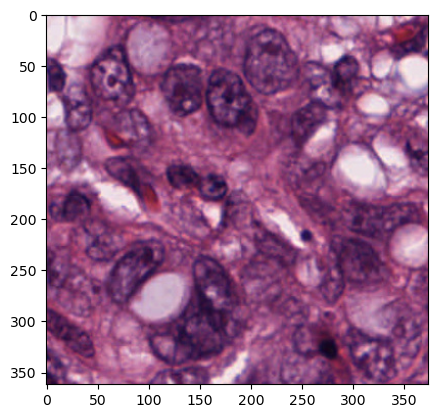

In [14]:
im_files = get_files(im_dir)
img_array = get_im_data(im_dir, im_files, 0)
print(img_array.shape)
plt.imshow(img_array)
plt.show()

In [15]:
csv_df = get_csv_df(csv_dir, csv_files, 0)
csv_df

,Unnamed: 0,raw_classification,main_classification,super_classification,type,xmin,ymin,xmax,ymax,coords_x,coords_y
0,0,lymphocyte,lymphocyte,sTIL,polyline,29,106,55,135,"47,29,35,45,53,55,53,51,47","133,106,106,109,117,123,131,135,133"
1,1,tumor,tumor_nonMitotic,tumor_any,polyline,104,225,152,280,"106,104,106,114,116,120,132,135,138,141,143,15...","269,259,251,228,226,225,225,226,228,231,236,25..."
2,2,tumor,tumor_nonMitotic,tumor_any,polyline,0,278,72,317,"0,0,5,8,20,27,46,51,55,69,71,72,71,67,64,56,37...","301,295,286,284,279,278,278,279,280,289,293,29..."
3,3,tumor,tumor_nonMitotic,tumor_any,polyline,48,237,99,296,"97,92,73,56,53,50,48,48,50,55,61,73,80,89,90,9...","278,296,293,280,278,272,265,263,257,241,237,23..."
4,4,apoptotic_body,AMBIGUOUS,AMBIGUOUS,polyline,100,104,138,136,"138,137,132,126,124,101,100,100,104,113,125,13...","121,131,136,136,135,121,116,112,107,104,104,10..."
5,5,fibroblast,nonTILnonMQ_stromal,nonTIL_stromal,polyline,100,47,135,88,"135,134,127,125,113,105,101,100,100,101,113,12...","84,88,88,86,77,68,62,59,51,47,51,64,77,84"
6,6,lymphocyte,lymphocyte,sTIL,polyline,127,147,155,180,"148,145,138,131,129,127,127,132,140,145,150,15...","178,180,179,175,168,162,157,152,147,148,153,15..."
7,7,unlabeled,AMBIGUOUS,AMBIGUOUS,polyline,163,285,190,322,"190,190,187,183,182,174,171,168,167,163,168,18...","293,297,310,321,322,322,321,320,314,291,285,28..."
8,8,unlabeled,AMBIGUOUS,AMBIGUOUS,polyline,258,289,280,338,"280,277,267,261,258,258,261,263,269,272,280","297,338,332,317,309,300,293,289,289,290,297"


In [16]:
matching_files = []
for csv in csv_files:
    for im in im_files:
        csv_d = os.path.splitext(csv)[0]
        im_d = os.path.splitext(im)[0]
        if csv_d == im_d:
            matching_files.append((csv,im))
print("Number of matching files =", len(matching_files))
matching_files[0]

Number of matching files = 1337


('SP.3_#_E_#_TCGA-E2-A158-01Z-00-DX1_id-5e83b15bddda5f83987d58dd_left-57092_top-27151_bottom-27425_right-57362.csv',
 'SP.3_#_E_#_TCGA-E2-A158-01Z-00-DX1_id-5e83b15bddda5f83987d58dd_left-57092_top-27151_bottom-27425_right-57362.png')

In [17]:
csv_dir = "../DATASET/csv"
im_dir = "../DATASET/rgb"
csv_files = get_files(csv_dir)
im_files = get_files(im_dir)
im_save_dir = "../DATASET/nuc"
class_map = {'raw_classification':0, "main_classification":1, 'super_classification':2}
org_class = class_map['super_classification']
pickle_array = []

final_df = pd.DataFrame(columns=["file_name", 'raw_classification', "main_classification",'super_classification'])
iters = 0
stop = 100
for i, files in enumerate(matching_files):
    csv_path = os.path.join(csv_dir, files[0])
    csv_df = pd.read_csv(csv_path)
    
    im_path = os.path.join(im_dir, files[1])
    img = plt.imread(im_path)
    
    try: 
        nucs = get_nuc(img, csv_df, xshape = 80, yshape = 80, x_window = [25,75], y_window = [25,75])
    except IndexError:
        print(files)
        continue
        
    for j, nuc in enumerate(nucs):
        label_df = csv_df[['raw_classification', "main_classification", 'super_classification']].iloc[j]
        label = label_df.to_numpy()
        
        if 'unlabeled' not in label and 'AMBIGUOUS' not in label and np.mean(nuc) > 0:
            im_name = f"im_{iters}.png"
            pickle = [nuc.transpose(2,0,1), label]
            pickle_array.append(pickle)
            # directory = os.path.join(im_save_dir, label[org_class])
            # if not os.path.exists(directory):
            #     os.makedirs(directory)

            # plt.imsave(os.path.join(directory, im_name), nuc)
            # plt.imsave(os.path.join(im_save_dir, im_name), nuc)
            
            # Create a new DataFrame row with the correct structure
            # new_row = pd.DataFrame({
            #     "file_name": [im_name], 
            #     'raw_classification': [label_df['raw_classification']], 
            #     "main_classification": [label_df['main_classification']],
            #     'super_classification': [label_df['super_classification']]
            # })
            
            # Concatenate the new row to the final_df DataFrame
            # final_df = pd.concat([final_df, new_row], ignore_index=True)
            
            # plt.imshow(nuc)
            # plt.show()
            # print(label_df)
            # iters += 1
            
    #     if iters == stop:
    #         break
    # if iters == stop:
    #             break
        
# final_df.to_excel(os.path.join(im_save_dir, "labels.xlsx"), index=False)
# final_df
len(pickle_array)

28130

# Pickle Object

In [18]:
import pickle
pickle_path = os.path.join(im_save_dir, 'nuc_data.pkl')
with open(pickle_path, 'wb') as f:
    pickle.dump(pickle_array, f)

# Load Pickled Object

In [19]:
def load_dataset(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data 

data = load_dataset(pickle_path)

In [20]:
data[0][0].shape

(3, 80, 80)

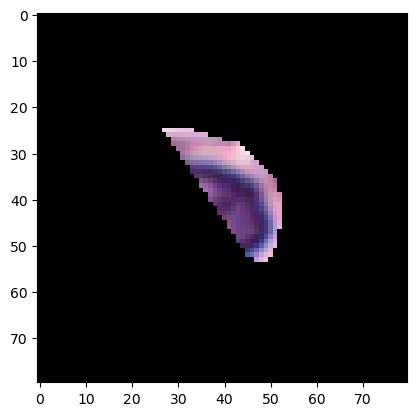

['lymphocyte' 'lymphocyte' 'sTIL']


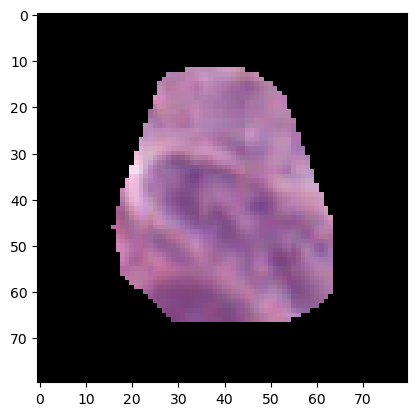

['tumor' 'tumor_nonMitotic' 'tumor_any']


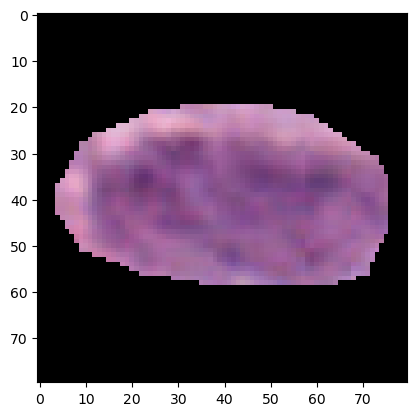

['tumor' 'tumor_nonMitotic' 'tumor_any']


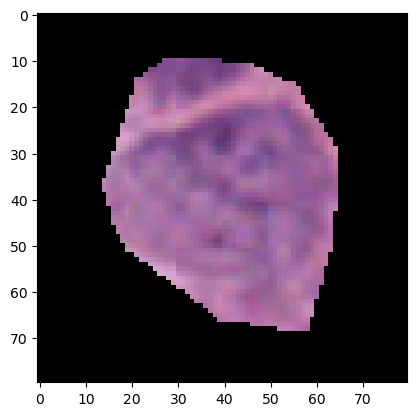

['tumor' 'tumor_nonMitotic' 'tumor_any']


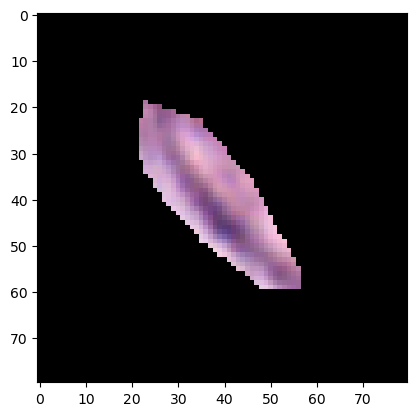

['fibroblast' 'nonTILnonMQ_stromal' 'nonTIL_stromal']


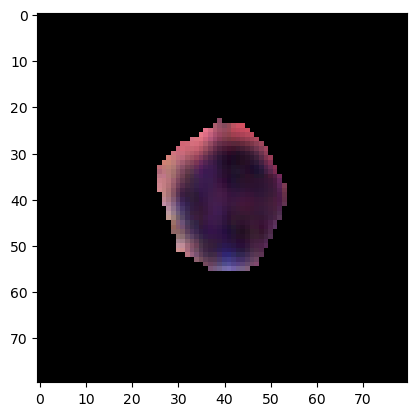

['lymphocyte' 'lymphocyte' 'sTIL']


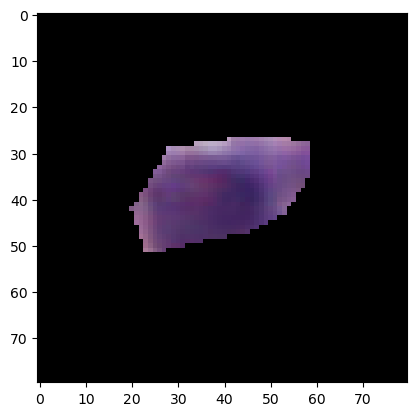

['lymphocyte' 'lymphocyte' 'sTIL']


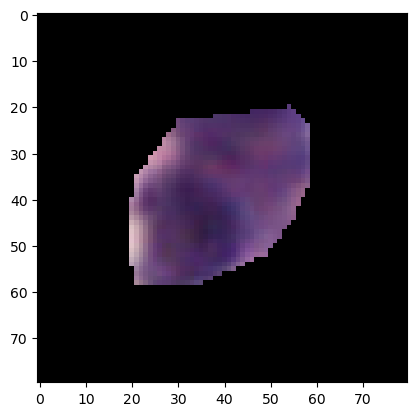

['lymphocyte' 'lymphocyte' 'sTIL']


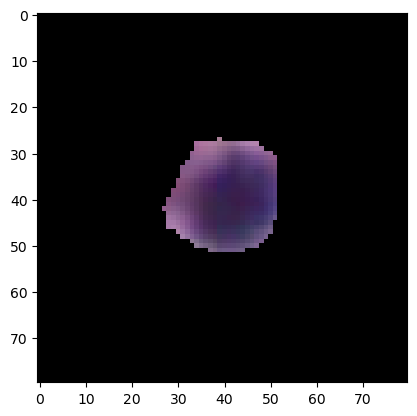

['lymphocyte' 'lymphocyte' 'sTIL']


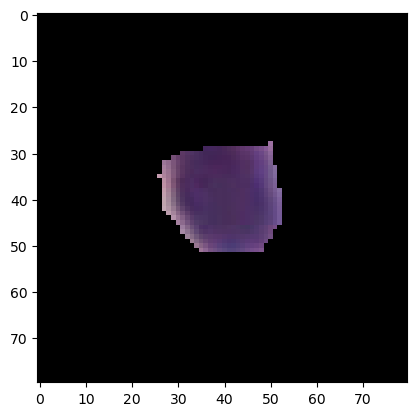

['lymphocyte' 'lymphocyte' 'sTIL']


In [21]:
for i in range(10):
    plt.imshow(data[i][0].transpose(1,2,0))
    plt.show()
    print(data[i][1])

In [22]:
# nuc_files = get_files(im_save_dir)
# nuc_df = pd.read_excel(os.path.join(im_save_dir, "labels.xlsx"))
# nuc_df.head(), print(len(nuc_files))

In [23]:
# im_list = []
# for i, nuc in enumerate(nuc_files):
#     if nuc.endswith(".png"):
#         img = plt.imread(os.path.join(im_save_dir, nuc))[:,:,:3]
#         im_list.append(img)
#         # plt.imshow(img)
#         # print(img.shape)
#         # break 
# X = np.stack(im_list, axis=0)
# X = X.transpose(0,3,1,2)
# y = nuc_df['super_classification'].to_numpy()
# X.shape

# Quick TSNE check

In [24]:
# from sklearn.manifold import TSNE
# import seaborn as sns
# tsne = TSNE(n_components=2)
# # TODO: Run t-SNE on X
# X_tsne = tsne.fit_transform(X.reshape(-1, 100*100*3))
# plt.figure(figsize=(10,10))
# sns.scatterplot(
#     x=X_tsne[:,0], y=X_tsne[:,1],
#     hue=y,
#     palette=sns.color_palette("hls", 10),
#     legend="full",
#     alpha=0.75
# )
# plt.show()